In [12]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d
import pdb

#### ODE 
- mutants densest: we use delta between 0 and 1
- wildtypes slowest: we use rho 
- mutants here have ne higher degradation rate 

In [17]:
mu=0.05
c=0.01
delta=0.5
K=500
T=5000
sto_realisations=50
rho=0.02 ## wildtypes slowest 

In [18]:
#we had here rho for wildtype to make them slower 
def F(X,t):
    w,m=X[0],X[1]
    return (c*w*(K-w-delta*m) , c*m*(K-w-delta*m))

temps=np.linspace(0,5000,5000)
sol=odeint(F,[40,10],temps)


In [19]:
w=sol[:,0]
m=sol[:,1]
h=m/(w+m)

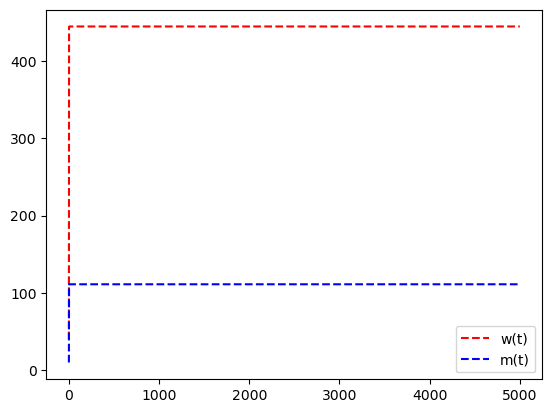

In [20]:
plt.plot(temps, w, "r--",label='w(t)')
plt.plot(temps, m,"b--",label="m(t)")
# Ajout de légendes
plt.legend()

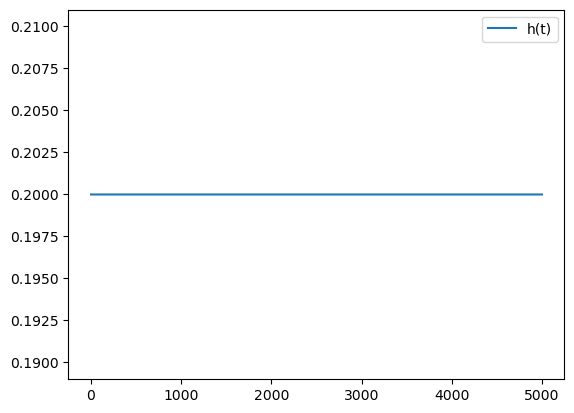

In [21]:
plt.plot(temps,h,label='h(t)')
plt.legend()

### stochastic 

In [38]:
mu=0.05
c=0.01
delta=0.5
K=100
T=5000
sto_realisations=50

# Matrice de stoichiométrie
V = np.array([[-1, 0, 1, 0],
              [0, -1, 0, 1]])

In [39]:
rho_max= - mu * (delta-1)
print(rho_max)
rho = random.uniform(0, rho_max)
rho_neg= 2

0.025


In [40]:
h0=0.2

#on essaye d'éviter la division par 0 rho==0 and h0==1
if (delta==0 and h0==1): 
    w0=0
    m0=K
else:
    w0 = (1-h0)*K/(1-h0+delta*h0)
    m0 = h0*K/(1-h0+delta*h0)

# Initialisation de l'état initial
X = np.array([w0,m0])
print(X)

[88.88888889 22.22222222]


In [41]:
def rate_function(rates):
    return max(rates,0)  

In [42]:
from tqdm import tqdm
# Simulation des populations
all_times = []
all_populations = []

for sim in tqdm(range(sto_realisations), desc="Simulations"):
    t = 0
    times_sim = [t]
    X = np.array([w0,m0])
    pop_sim = [X.copy()]
   

    while t <= T:
        # Calcul des taux
        a = np.array([rate_function((mu - rho_neg)* X[0]),
                      rate_function(mu * X[1]),
                      rate_function((mu - rho_neg+ c * (K - X[0] - delta*X[1]))*X[0]),
                      rate_function((mu +c * (K - X[0] - delta*X[1]))*X[1])])
        
        
        # Somme des taux
        somme = np.sum(a)
        # Debug print
        #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
        if somme==0:
            print('No more events possible, breaking out of the loop.')
            #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
            break 
            
         # Sélection de la réaction
        r1 = np.random.rand()
        r_compare= r1*somme
        
        cumulative_sum = np.cumsum(a)
        j = np.searchsorted(cumulative_sum, r_compare)
        # Debugging information
        #print(f'Random number ξ1: {r1}')
        #print(f'Threshold for reaction selection: {r_compare}')
        #print(f'Cumulative sums: {cumulative_sum}, Selected reaction: {j}')
        
           # Vérification que j est bien sélectionné parmi les réactions disponibles
        if j >= len(a):
            print(f'Error: j ({j}) is out of bounds for array a with length {len(a)}.')
            break
            
            
        X += V[:, j ]
        
        
        # Calcul du temps d'événement
        r2 = np.random.rand()
        tau = np.log(1 / r2) / somme
        
        # Mettre à jour le temps
        t += tau
        if t > T:
            break
        times_sim.append(t)
        pop_sim.append(X.copy())
    
    # Enregistrer les résultats de la simulation
    all_times.append(times_sim)
    all_populations.append(pop_sim)


Simulations: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


In [43]:
total_time=5000
time_points = np.linspace(0, total_time, num=20)


# Calculer la fraction de mutants et l'ensemble moyen
h_ensemble = np.zeros((len(time_points), sto_realisations))
m_ensemble=np.zeros((len(time_points), sto_realisations))
w_ensemble=np.zeros((len(time_points), sto_realisations))



for i in range(sto_realisations):
    times = all_times[i]
    populations = all_populations[i]
    
    for idx, t in enumerate(time_points):
        if t <= times[-1]:
            j = np.searchsorted(times, t)
            W, M = populations[j] if j < len(populations) else populations[-1]
            h_ensemble[idx, i] = M / (W + M)
            m_ensemble[idx,i]=M
            w_ensemble[idx,i]=W
        else:
            h_ensemble[idx, i] = h_ensemble[idx - 1, i]
            m_ensemble[idx, i] = m_ensemble[idx - 1, i]
            w_ensemble[idx, i] = w_ensemble[idx - 1, i]

h_mean = np.mean(h_ensemble, axis=1)
m_mean = np.mean(m_ensemble, axis=1)
w_mean = np.mean(w_ensemble, axis=1)

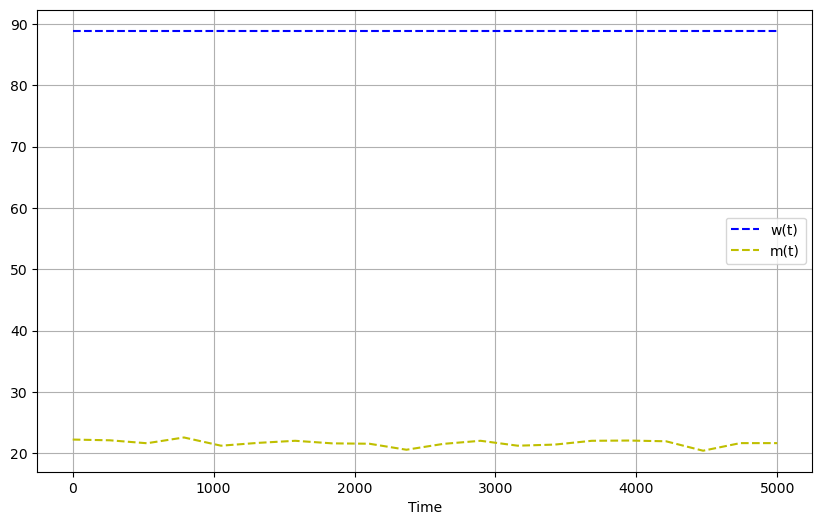

In [44]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.plot(time_points,w_mean,"b--",label="w(t)")
plt.plot(time_points,m_mean,"y--",label="m(t)")
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
m_std=np.std(m_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
m_sem = m_std/ np.sqrt(sto_realisations)
m_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0.        , 0.3874429 , 0.40987803, 0.44146121, 0.41761226,
       0.40910634, 0.40099875, 0.44890088, 0.51802703, 0.4504309 ,
       0.42166337, 0.44988888, 0.35888717, 0.46792307, 0.45077711,
       0.39835662, 0.44814283, 0.44693624, 0.46997021, 0.46997021])

In [46]:
w_std=np.std(w_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w_sem = w_std/ np.sqrt(sto_realisations)
w_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

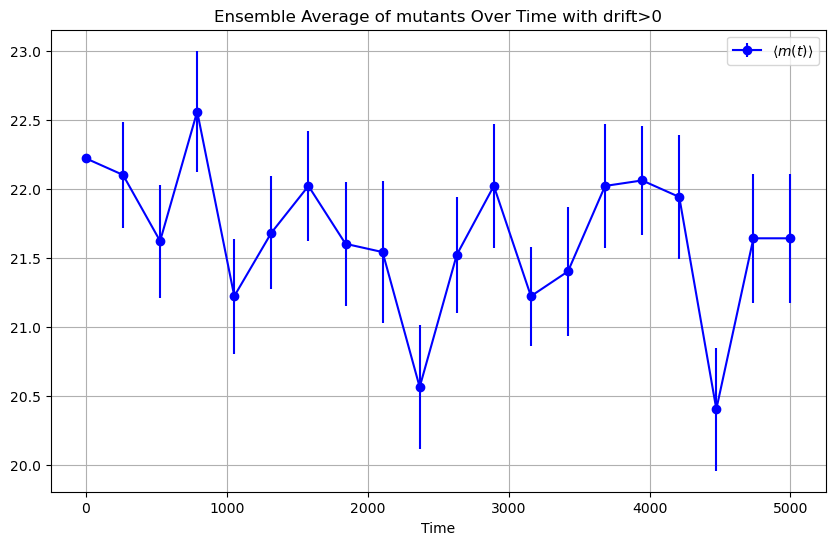

In [48]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, m_mean, yerr=m_sem, fmt='b-', marker='o', label=r'$\langle m(t) \rangle$')
#plt.errorbar(time_points, w_mean, yerr=w_sem, fmt='y-', marker='o', label=r'$\langle w(t) \rangle$')
plt.xlabel('Time')
plt.title('Ensemble Average of mutants Over Time with drift>0')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
h_std=np.std(h_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h_sem = h_std/ np.sqrt(sto_realisations)
h_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([7.85046229e-18, 1.05453595e-02, 1.88073401e-02, 1.96964923e-02,
       2.12765388e-02, 2.12272628e-02, 2.21394158e-02, 2.35594243e-02,
       2.19005681e-02, 2.24054368e-02, 2.31179993e-02, 2.49081617e-02,
       2.59780780e-02, 2.66244931e-02, 2.70574143e-02, 2.47783600e-02,
       2.41217109e-02, 2.51661281e-02, 2.28442618e-02, 2.28442618e-02])

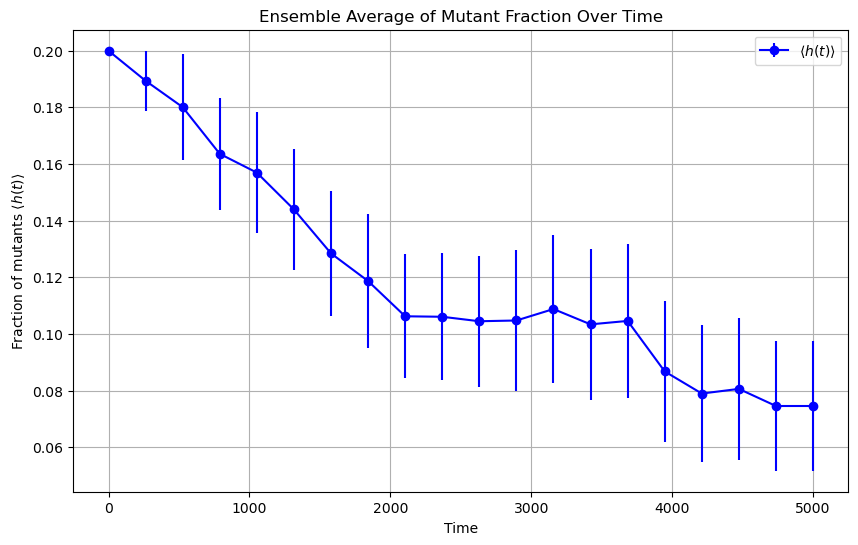

In [37]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

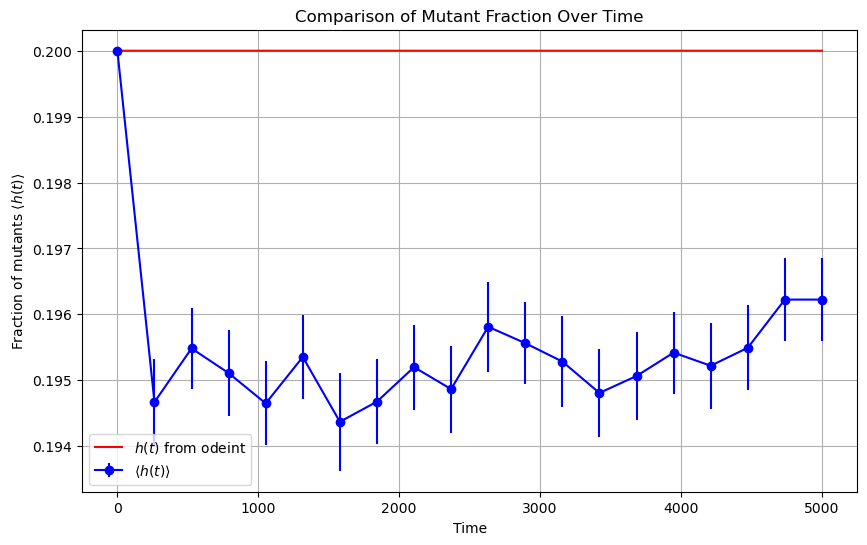

In [75]:

# Tracé des courbes
plt.figure(figsize=(10, 6))

# Tracer la courbe obtenue à partir des simulations
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
# Tracer la courbe obtenue avec odeint
plt.plot(temps, h, 'r-', label=r'$h(t)$ from odeint')

# Ajout de légendes
plt.legend()

# Ajout de titres et d'étiquettes d'axes
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Comparison of Mutant Fraction Over Time')
plt.grid(True)

# Affichage du graphe
plt.show()
